In [1]:
#Import required libraries and files
import numpy as np
import pandas as pd
import sys

from Ensembles import Graph_ensemble #do_graph(list_ensembles, nEnsCluster=5, iterations=10, verbose = True, N_clusters_max = 5, hdf5_file_name=None)
from Ensembles import Mixture_Models#.do_mixturemodels(list_ensembles, nEnsCluster=5, iterations=10, verbose = True, N_clusters_max = 5, hdf5_file_name=None)
from Ensembles import Voting#.do_voting(list_ensembles, nEnsCluster=5, iterations=10, verbose = True, N_clusters_max = 5, hdf5_file_name=None
from Ensembles import Simple_GMM
from Ensembles import Multivariate_GMM

## Example Using Iris Dataset

### Use an ensemble method for get a final partition
### Available ensembels:
    Graph ensemble
    Mixture Models
    Voting
    Gaussian Mixture Model
    Multivariate GMM

In [2]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

data = load_iris()
c = data['target']
x = data['data']

#Get 3 elements for the ensemble using different number of clusters in KMeans
labels_array=[]

for n in range(3,6):
    k = KMeans(n_clusters=n).fit_predict(x)
    labels_array.append(k)



## Find best number of K for ensemble
We will treat the labels in each clustering as categorical features and we will calculate the distance between these using Gower distancec and then we will use the generated matrix distance for calculate Silhouette index

### Gower Distance

In [3]:
#https://sourceforge.net/projects/gower-distance-4python/files/

from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
# Vectorized Version
def gower_distances(X, Y=None, feature_weight=None, categorical_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    
    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.
        
        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.

    """
    
    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")
        
    y_none = Y is None
    
    
    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    array_type = np.object
    # this is necessary as strangelly the validator is rejecting numeric
    # arrays with NaN
    if  np.issubdtype(X.dtype, np.number) and (np.isfinite(X.sum()) or np.isfinite(X).all()):
        array_type = type(np.zeros(1,X.dtype).flat[0])
    
    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)
    
    n_rows, n_cols = X.shape
    
    if categorical_features is None:
        categorical_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                categorical_features[col]=True
    else:          
        categorical_features = np.array(categorical_features)
    
    
    #if categorical_features.dtype == np.int32:
    if np.issubdtype(categorical_features.dtype, np.int):
        new_categorical_features = np.zeros(n_cols, dtype=bool)
        new_categorical_features[categorical_features] = True
        categorical_features = new_categorical_features
    
    print(categorical_features)
  
    # Categorical columns
    X_cat =  X[:,categorical_features]
    
    # Numerical columns
    X_num = X[:,np.logical_not(categorical_features)]
    ranges_of_numeric = None
    max_of_numeric = None
    
        
    # Calculates the normalized ranges and max values of numeric values
    _ ,num_cols=X_num.shape
    ranges_of_numeric = np.zeros(num_cols)
    max_of_numeric = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_numeric[col] = max
        ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0


    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(X_num ,max_of_numeric,out=np.zeros_like(X_num), where=max_of_numeric!=0)

    
    if feature_weight is None:
        feature_weight = np.ones(n_cols)
        
    feature_weight_cat=feature_weight[categorical_features]
    feature_weight_num=feature_weight[np.logical_not(categorical_features)]
    
    
    y_n_rows, _ = Y.shape
    
    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)
        
    feature_weight_sum = feature_weight.sum()

    Y_cat=None
    Y_num=None
    
    if not y_none:
        Y_cat = Y[:,categorical_features]
        Y_num = Y[:,np.logical_not(categorical_features)]
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(Y_num ,max_of_numeric,out=np.zeros_like(Y_num), where=max_of_numeric!=0)
    else:
        Y_cat=X_cat
        Y_num = X_num
        
    for i in range(n_rows):
        j_start= i
        
        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

      
        Y_cat[j_start:n_rows,:]
        Y_num[j_start:n_rows,:]
        result= _gower_distance_row(X_cat[i,:], X_num[i,:],Y_cat[j_start:n_rows,:],
                                    Y_num[j_start:n_rows,:],feature_weight_cat,feature_weight_num,
                                    feature_weight_sum,categorical_features,ranges_of_numeric,
                                    max_of_numeric) 
        dm[i,j_start:]=result
        dm[i:,j_start]=result
        

    return dm


def _gower_distance_row(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,feature_weight_num,
                        feature_weight_sum,categorical_features,ranges_of_numeric,max_of_numeric ):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute( xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    return sum_sij


def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

In [4]:
a=pd.DataFrame(labels_array).T
a=a.astype(str)

#D is the Distance matrix
D = gower_distances(a)

[ True  True  True]


/home/grecia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.


### Silhouette

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_range = np.arange(2,6,1)
silhouette_scores = []
likelihoods=[]

for num_clusters in cluster_range:
    clusters, likelihood = Multivariate_GMM.do_gmm(np.asarray(labels_array), nEnsCluster=num_clusters, iterations=10, verbose = True, N_clusters_max =num_clusters , hdf5_file_name=None)
    silhouette_scores.append( silhouette_score(D, clusters, metric="precomputed"))
    likelihoods.append(likelihood)

Text(0,0.5,'silhouette_scores')

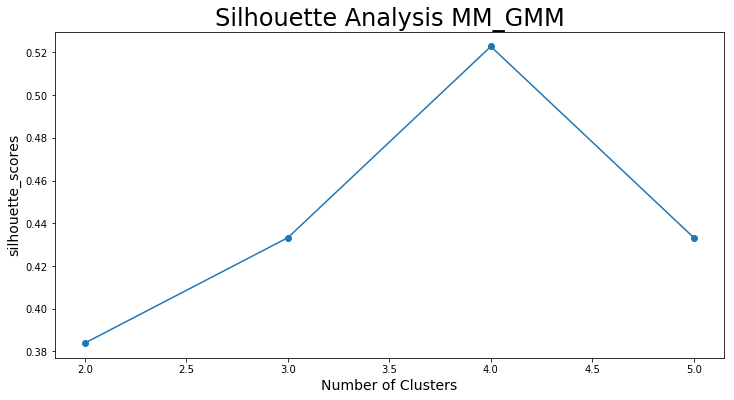

In [10]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "silhouette_scores": silhouette_scores, "likelihoods": likelihoods } )

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.silhouette_scores, marker = "o" )
plt.title('Silhouette Analysis MM_GMM',fontsize=24)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("silhouette_scores", fontsize=14)

Text(0,0.5,'Final Likelihood')

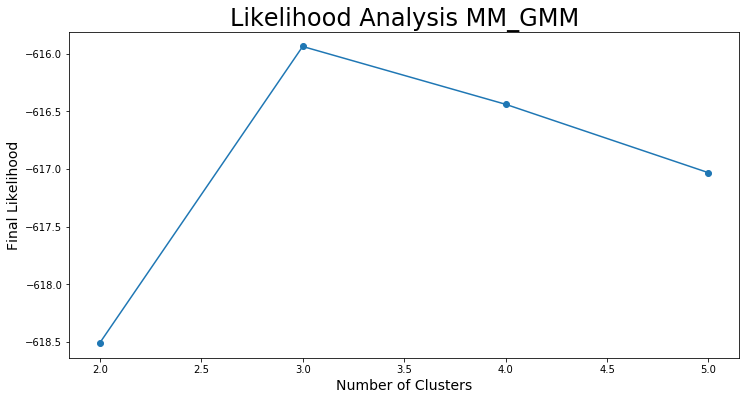

In [11]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.likelihoods, marker = "o" )
plt.title('Likelihood Analysis MM_GMM',fontsize=24)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Final Likelihood", fontsize=14)

We find that the optimal number of clusters is 3 because is when the silhouette score is closer to 1.

In [28]:
# Multivariate Gaussian Mixture Model
max_num_clusters=3

final_partition=Multivariate_GMM.do_gmm(np.asarray(labels_array), nEnsCluster=max_num_clusters, iterations=10, verbose = True, N_clusters_max =max_num_clusters , hdf5_file_name=None)

-590.2710767589383
-588.9365043927025
-588.1177698590847
-587.4687074924676
-586.9138280355735
-586.4074092715563
-585.8784764758915
-585.212368293566
-584.2294121157986
-582.6848151592087
found larger:  -582.6848151592087
-580.5625012694624
-578.2883011940199
-576.4436909921327
-574.8794907516271
-573.5257569690709
-572.2523058656077
-570.8511306052116
-568.9843014580943
-566.1481317188337
-562.1309002411524
found larger:  -562.1309002411524
-583.117144507103
-580.8668484641178
-578.8814616537057
-577.0242885329751
-575.3626862013682
-573.9876760357929
-572.9393973258063
-572.1724555556433
-571.5993020275587
-571.1463478925878
-593.7180142120844
-592.890344249189
-592.4011560396597
-592.0592192152551
-591.7867072227939
-591.5544444810052
-591.3441939866088
-591.1404498893769
-590.9277950466364
-590.6863615362715
-590.5601630178608
-589.3801488902526
-588.6996954779097
-588.1843189304224
-587.7488537077589
-587.3806538190632
-587.0650502170769
-586.7822481395302
-586.5179551007138
-586

In [44]:
a['super_cluster']=final_partition
a.head()

,0,1,2,super_cluster
0,1,1,1,0.0
1,1,1,1,0.0
2,1,1,1,0.0
3,1,1,1,0.0
4,1,1,1,0.0
